# 📈 Algorithmic Trading: Implementing and Analyzing 5 Powerful Strategies in Python

This notebook demonstrates algorithmic trading implementation and performance analysis of five trading strategies:

1. **Monthly Portfolio Rebalancing**
2. **Momentum Investing**
3. **Resistance Breakout**
4. **Renko & On Balance Volume (OBV)**
5. **Renko & Moving Average Convergence Divergence (MACD)**

Each section includes strategy explanation, Python implementation, visualization, and performance evaluation using KPIs like CAGR, Sharpe Ratio, and Max Drawdown.


In [2]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm 
import datetime as dt
from itertools import islice
from alpha_vantage.timeseries import TimeSeries
import time
import requests
import copy
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from stocktrends import Renko
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import nbconvert

## 🔄 Monthly Portfolio Rebalancing

**Strategy Overview:**
Monthly portfolio rebalancing involves periodically adjusting the portfolio to maintain desired asset allocation, buying underweighted assets and selling overweighted assets.

**Methodology:**
- Calculate monthly returns for stocks.
- Rank stocks based on performance.
- Rotate out underperforming stocks, reinvesting into better performers.

**Performance Metrics:**
- **CAGR (Cumulative Annual Growth Rate)**: Measures annual return.
- **Sharpe Ratio**: Indicates return relative to risk.
- **Max Drawdown**: Indicates the maximum observed loss from peak to trough.


In [2]:
#We will use '12' instead of '250' here since we are working with monthly returns
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
# get ohlcv data (Open, High, Low, Close and Volume) for any ticker by period.
data = yf.download("MSFT", period='1mo', interval="5m")

# get ohlcv data (Open, High, Low, Close and Volume) for any ticker by start date and end date
data = yf.download("MSFT", start="2017-01-01", end = "2025-01-01")

# get intraday data (every 5 mins) for any ticker by period.
data = yf.download("MSFT", period='1mo', interval="5m")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Download historical data for required stocks
tickers = ["AMZN","GOOG","MSFT"]
ohlcv_data = {}

# looping over tickers and storing OHLCV dataframe in dictionary
for ticker in tickers:
    temp = yf.download(ticker,period='1mo',interval='5m', auto_adjust = False)
    temp.dropna(how="any",inplace=True)
    ohlcv_data[ticker] = temp

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Download historical data (monthly) for DJI constituent stocks

tickers = ["AMZN","VTI","VWO","VEA","BND","AAPL","IVV", "SPY","VNO","TSLA","MSFT",
           "GOOGL","CRM","KO","VUG","VOO","JNJ","NVDA","BA","INTC","LEG",
           "MMM","IBM","CVX","PG","AVGO", "GLD", "HDV", "VYM", "SPYD"]

ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo', auto_adjust = False)
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

print(return_df.head(10))

calculating monthly return for  AMZN
calculating monthly return for  VTI
calculating monthly return for  VWO
calculating monthly return for  VEA
calculating monthly return for  BND
calculating monthly return for  AAPL
calculating monthly return for  IVV
calculating monthly return for  SPY
calculating monthly return for  VNO
calculating monthly return for  TSLA
calculating monthly return for  MSFT
calculating monthly return for  GOOGL
calculating monthly return for  CRM
calculating monthly return for  KO
calculating monthly return for  VUG
calculating monthly return for  VOO
calculating monthly return for  JNJ
calculating monthly return for  NVDA
calculating monthly return for  BA
calculating monthly return for  INTC
calculating monthly return for  LEG
calculating monthly return for  MMM
calculating monthly return for  IBM
calculating monthly return for  CVX
calculating monthly return for  PG
calculating monthly return for  AVGO
calculating monthly return for  GLD
calculating monthly re

In [7]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio (6 for our strategy)
    x = number of underperforming stocks to be removed from portfolio monthly (3 for our strategy)"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            #Append the monthly returns of each row to the df
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            #Identify bad stocks by sorting the values of returns in ascending order, picking top x (3), 
            # and then assigning index to the stock tickers and getting them as a list since the values are in column format
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            #removing one list from another - removing the bad stocks
            #looking at portfolio, I want my values in portfolio to be all of the portfolio such that they are not in bad stocks
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df[[t for t in tickers if t not in portfolio]].iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [8]:
#calculating overall strategy's KPIs
print(CAGR(pflio(return_df,6,3)))
print(sharpe(pflio(return_df,6,3),0.045))
print(max_dd(pflio(return_df,6,3)) )

['NVDA', 'TSLA', 'AMZN', 'AVGO', 'LEG', 'GOOGL']
['NVDA', 'TSLA', 'AVGO', 'PG', 'VNO', 'MSFT']
['AVGO', 'PG', 'MSFT', 'GLD', 'BND', 'JNJ']
['GLD', 'BND', 'JNJ', 'LEG', 'NVDA', 'IBM']
['LEG', 'NVDA', 'IBM', 'TSLA', 'CVX', 'AVGO']
['LEG', 'TSLA', 'CVX', 'AMZN', 'BA', 'GLD']
['LEG', 'CVX', 'AMZN', 'NVDA', 'CRM', 'AAPL']
['LEG', 'CVX', 'NVDA', 'GLD', 'JNJ', 'VNO']
['LEG', 'NVDA', 'VNO', 'GOOGL', 'MSFT', 'TSLA']
['LEG', 'NVDA', 'MSFT', 'AVGO', 'INTC', 'PG']
['NVDA', 'INTC', 'PG', 'AMZN', 'AAPL', 'CVX']
['NVDA', 'AAPL', 'CVX', 'BA', 'CRM', 'MSFT']
['NVDA', 'CVX', 'BA', 'IBM', 'VNO', 'SPYD']
['NVDA', 'CVX', 'VNO', 'TSLA', 'AAPL', 'INTC']
['NVDA', 'TSLA', 'AAPL', 'CRM', 'AVGO', 'AMZN']
['AAPL', 'CRM', 'AVGO', 'BA', 'JNJ', 'MMM']
['AAPL', 'AVGO', 'MMM', 'TSLA', 'NVDA', 'AMZN']
['MMM', 'TSLA', 'AMZN', 'GOOGL', 'LEG', 'BA']
['TSLA', 'AMZN', 'GOOGL', 'NVDA', 'AVGO', 'AAPL']
['TSLA', 'AMZN', 'NVDA', 'BA', 'JNJ', 'VNO']
['NVDA', 'BA', 'VNO', 'AVGO', 'VWO', 'MSFT']
['NVDA', 'VWO', 'MSFT', 'AAPL', 'TS

['NVDA', 'VWO', 'MSFT', 'CVX', 'INTC', 'BA']
['NVDA', 'MSFT', 'INTC', 'AMZN', 'AAPL', 'MMM']
['AMZN', 'AAPL', 'MMM', 'BA', 'AVGO', 'PG']
['AMZN', 'BA', 'PG', 'CVX', 'INTC', 'VWO']
['AMZN', 'BA', 'VWO', 'NVDA', 'TSLA', 'GOOGL']
['AMZN', 'BA', 'NVDA', 'AAPL', 'INTC', 'CRM']
['NVDA', 'INTC', 'CRM', 'CVX', 'LEG', 'VNO']
['CRM', 'CVX', 'VNO', 'TSLA', 'AMZN', 'MSFT']
['CRM', 'AMZN', 'MSFT', 'AAPL', 'NVDA', 'AVGO']
['CRM', 'AMZN', 'MSFT', 'TSLA', 'LEG', 'VNO']
['CRM', 'AMZN', 'MSFT', 'JNJ', 'GOOGL', 'MMM']
['CRM', 'AMZN', 'MSFT', 'AAPL', 'NVDA', 'VNO']
['CRM', 'MSFT', 'NVDA', 'AVGO', 'BA', 'IBM']
['MSFT', 'AVGO', 'BA', 'TSLA', 'PG', 'KO']
['AVGO', 'PG', 'KO', 'MMM', 'IBM', 'LEG']
['AVGO', 'PG', 'KO', 'GLD', 'BND', 'VWO']
['AVGO', 'PG', 'VWO', 'BA', 'IBM', 'LEG']
['PG', 'BA', 'LEG', 'INTC', 'CRM', 'NVDA']
['PG', 'INTC', 'NVDA', 'AAPL', 'AVGO', 'AMZN']
['AAPL', 'AVGO', 'AMZN', 'MSFT', 'KO', 'VUG']
['MSFT', 'KO', 'VUG', 'BND', 'GLD', 'PG']
['MSFT', 'GLD', 'PG', 'NVDA', 'TSLA', 'AVGO']
['PG', 'NV

In [9]:
#calculating KPIs for Index buy and hold strategy over the same period
DJI = yf.download("^DJI",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo', auto_adjust = False)
DJI["mon_ret"] = DJI["Adj Close"].pct_change().fillna(0)
print(CAGR(DJI))
print(sharpe(DJI,0.045))
print(max_dd(DJI))

[*********************100%***********************]  1 of 1 completed

0.08071591408241496
0.22840274202991068
0.23201266165063417


In [10]:
#calculating KPIs for Index buy and hold strategy over the same period
SP_500 = yf.download("SPY",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo', auto_adjust = False)
SP_500["mon_ret"] = SP_500["Adj Close"].pct_change().fillna(0)
print(CAGR(SP_500))
print(sharpe(SP_500,0.045))
print(max_dd(SP_500))

[*********************100%***********************]  1 of 1 completed

0.11474743200977011
0.44061988228133087
0.23972200612730435


['NVDA', 'TSLA', 'AMZN', 'AVGO', 'LEG', 'GOOGL']
['NVDA', 'TSLA', 'AVGO', 'PG', 'VNO', 'MSFT']
['AVGO', 'PG', 'MSFT', 'GLD', 'BND', 'JNJ']
['GLD', 'BND', 'JNJ', 'LEG', 'NVDA', 'IBM']
['LEG', 'NVDA', 'IBM', 'TSLA', 'CVX', 'AVGO']
['LEG', 'TSLA', 'CVX', 'AMZN', 'BA', 'GLD']
['LEG', 'CVX', 'AMZN', 'NVDA', 'CRM', 'AAPL']
['LEG', 'CVX', 'NVDA', 'GLD', 'JNJ', 'VNO']
['LEG', 'NVDA', 'VNO', 'GOOGL', 'MSFT', 'TSLA']
['LEG', 'NVDA', 'MSFT', 'AVGO', 'INTC', 'PG']
['NVDA', 'INTC', 'PG', 'AMZN', 'AAPL', 'CVX']
['NVDA', 'AAPL', 'CVX', 'BA', 'CRM', 'MSFT']
['NVDA', 'CVX', 'BA', 'IBM', 'VNO', 'SPYD']
['NVDA', 'CVX', 'VNO', 'TSLA', 'AAPL', 'INTC']
['NVDA', 'TSLA', 'AAPL', 'CRM', 'AVGO', 'AMZN']
['AAPL', 'CRM', 'AVGO', 'BA', 'JNJ', 'MMM']
['AAPL', 'AVGO', 'MMM', 'TSLA', 'NVDA', 'AMZN']
['MMM', 'TSLA', 'AMZN', 'GOOGL', 'LEG', 'BA']
['TSLA', 'AMZN', 'GOOGL', 'NVDA', 'AVGO', 'AAPL']
['TSLA', 'AMZN', 'NVDA', 'BA', 'JNJ', 'VNO']
['NVDA', 'BA', 'VNO', 'AVGO', 'VWO', 'MSFT']
['NVDA', 'VWO', 'MSFT', 'AAPL', 'TS

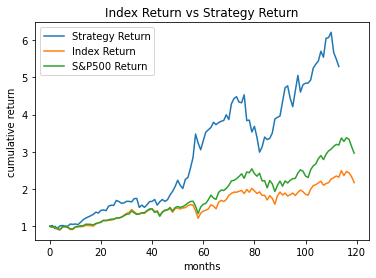

In [11]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.plot((1+SP_500["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return", "S&P500 Return"])

**📊 Performance Summary**:
- CAGR: **19.16%**
- Sharpe Ratio: **0.736**
- Maximum Drawdown: **33.98%**

This strategy significantly outperformed benchmarks such as DJI and S&P 500 during the analysis period.


-------------------------------------------------------------------------------------------------------------------------------

## 🚀 Momentum Investing Strategy

**Strategy Overview:**
Momentum investing buys securities showing upward price trends and sells those trending downward, capitalizing on continuation of price trends.

**Implementation Highlights:**
- Calculate momentum based on percentage price change.
- Define clear buy and sell signals.

**Visual Representation:**
Momentum and corresponding buy/sell markers are displayed for easy visualization.


In [6]:
# Get Apple's stock data from yahoo finance
stock = yf.Ticker("SPY")
data = stock.history(period="1y")
print(data.head())

                                 Open        High         Low       Close  \
Date                                                                        
2024-04-18 00:00:00-04:00  495.671354  497.794328  492.294322  493.242249   
2024-04-19 00:00:00-04:00  493.163283  494.170453  487.653392  488.937073   
2024-04-22 00:00:00-04:00  491.573496  496.066332  489.203665  493.439758   
2024-04-23 00:00:00-04:00  495.473868  499.729700  493.252145  499.295227   
2024-04-24 00:00:00-04:00  500.193769  500.993587  496.806883  499.058228   

                              Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                          
2024-04-18 00:00:00-04:00   74548100        0.0           0.0            0.0  
2024-04-19 00:00:00-04:00  102129100        0.0           0.0            0.0  
2024-04-22 00:00:00-04:00   67961000        0.0           0.0            0.0  
2024-04-23 00:00:00-04:00   64633600        0.0           0.0    

## Calculation of Momentum

In [7]:
# Calculation of momentum
data['momentum'] = data['Close'].pct_change()

## Buying/Selling Markers

In [8]:
# Creating subplots to show momentum and buying/selling markers
figure = make_subplots(rows=2, cols=1)
figure.add_trace(go.Scatter(x=data.index, 
                         y=data['Close'], 
                         name='Close Price'))
figure.add_trace(go.Scatter(x=data.index, 
                         y=data['momentum'], 
                         name='Momentum', 
                         yaxis='y2'))

## Buy & Sell Signals

In [9]:
# Adding the buy and sell signals
figure.add_trace(go.Scatter(x=data.loc[data['momentum'] > 0].index, 
                         y=data.loc[data['momentum'] > 0]['Close'], 
                         mode='markers', name='Sell', 
                         marker=dict(color='Red', symbol='triangle-down')))

figure.add_trace(go.Scatter(x=data.loc[data['momentum'] < 0].index, 
                         y=data.loc[data['momentum'] < 0]['Close'], 
                         mode='markers', name='Buy', 
                         marker=dict(color='Green', symbol='triangle-up')))

figure.update_layout(title='Algorithmic Trading using Momentum Strategy',
                  xaxis_title='Date',
                  yaxis_title='Price')
figure.update_yaxes(title="Momentum", secondary_y=True)
figure.show()

**🔍 Visualization Insight:**
- 🟢 Green triangles: **Buy signals** when momentum turns positive.
- 🔴 Red triangles: **Sell signals** when momentum turns negative.

The chart clearly illustrates how momentum informs timely trade decisions.


## 📉 Intraday Resistance Breakout Strategy

**Strategy Overview:**
This strategy identifies price breakouts through previously established resistance levels, indicating potential upward price movements.

**Key Calculation - ATR (Average True Range):**
ATR measures market volatility. A breakout occurs when the price exceeds the upper resistance band calculated using ATR.

**Implementation Approach:**
- Compute ATR and establish resistance bands.
- Signal trades upon price breaching resistance levels.


In [16]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF, rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    vol = volatility(df)
    if vol == 0:         # ← guard zero‐vol case
        return np.nan    # or 0, or float('inf'), whichever you prefer
    return (CAGR(df) - rf) / vol

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [17]:
### Download historical data (monthly) for selected stocks

tickers = ["AMZN","AAPL","TSLA","MSFT","GOOGL","NVDA"]

ohlc_intraday = {}
start = '2025-04-11'
end = '2025-04-18'

for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker, start, end, interval='1m', auto_adjust=False)
    ohlc_intraday[ticker].dropna(inplace=True, how="all")

tickers = ohlc_intraday.keys()

ohlc_dict = copy.deepcopy(ohlc_intraday)

tickers_signal = {}
tickers_ret = {}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
ohlc_intraday

{'AMZN': Price                       Adj Close       Close        High         Low  \
 Ticker                           AMZN        AMZN        AMZN        AMZN   
 Datetime                                                                    
 2025-04-11 13:30:00+00:00  180.294998  180.294998  180.539993  179.009995   
 2025-04-11 13:31:00+00:00  179.963196  179.963196  180.529999  179.804993   
 2025-04-11 13:32:00+00:00  179.169998  179.169998  180.000000  179.040100   
 2025-04-11 13:33:00+00:00  179.479996  179.479996  179.740005  179.149994   
 2025-04-11 13:34:00+00:00  179.838303  179.838303  180.009995  179.250000   
 ...                               ...         ...         ...         ...   
 2025-04-17 19:55:00+00:00  172.428299  172.428299  172.680206  172.399994   
 2025-04-17 19:56:00+00:00  172.529999  172.529999  172.535004  172.339996   
 2025-04-17 19:57:00+00:00  172.544998  172.544998  172.649994  172.475006   
 2025-04-17 19:58:00+00:00  172.550003  172.550003  172.

In [19]:
ohlc_dict

{'AMZN': Price                       Adj Close       Close        High         Low  \
 Ticker                           AMZN        AMZN        AMZN        AMZN   
 Datetime                                                                    
 2025-04-11 13:30:00+00:00  180.294998  180.294998  180.539993  179.009995   
 2025-04-11 13:31:00+00:00  179.963196  179.963196  180.529999  179.804993   
 2025-04-11 13:32:00+00:00  179.169998  179.169998  180.000000  179.040100   
 2025-04-11 13:33:00+00:00  179.479996  179.479996  179.740005  179.149994   
 2025-04-11 13:34:00+00:00  179.838303  179.838303  180.009995  179.250000   
 ...                               ...         ...         ...         ...   
 2025-04-17 19:55:00+00:00  172.428299  172.428299  172.680206  172.399994   
 2025-04-17 19:56:00+00:00  172.529999  172.529999  172.535004  172.339996   
 2025-04-17 19:57:00+00:00  172.544998  172.544998  172.649994  172.475006   
 2025-04-17 19:58:00+00:00  172.550003  172.550003  172.

In [20]:
for ticker in tickers:
    print(f"Calculating ATR and rolling max/min price for {ticker}")
    ohlc_dict[ticker] = ohlc_dict[ticker].reset_index(drop=True)
    ohlc_dict[ticker]["ATR"]         = ATR(ohlc_dict[ticker], 20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"]= ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker]    = []     

# identifying signals and calculating returns (stop loss factored in)
for ticker in tickers:
    #tickers_ret[ticker].append(0)
    print("calculating returns for ", ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if (ohlc_dict[ticker]["High"].iloc[i] >=ohlc_dict[ticker]["roll_max_cp"].iloc[i]).item() and \
               (ohlc_dict[ticker]["Volume"].iloc[i]>1*ohlc_dict[ticker]["roll_max_vol"].iloc[i-1]).item() :
                tickers_signal[ticker] = "Buy"
            elif (ohlc_dict[ticker]["Low"].iloc[i]<=ohlc_dict[ticker]["roll_min_cp"].iloc[i]).item() and \
               (ohlc_dict[ticker]["Volume"].iloc[i]>1*ohlc_dict[ticker]["roll_max_vol"].iloc[i-1]).item():
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if (ohlc_dict[ticker]["Low"].iloc[i]<(ohlc_dict[ticker]["Close"].iloc[i-1] - ohlc_dict[ticker]["ATR"].iloc[i-1])).item():
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"].iloc[i-1] - ohlc_dict[ticker]["ATR"].iloc[i-1])/ohlc_dict[ticker]["Close"].iloc[i-1])-1)
            elif (ohlc_dict[ticker]["Low"].iloc[i]<=ohlc_dict[ticker]["roll_min_cp"].iloc[i]).item() and \
                (ohlc_dict[ticker]["Volume"].iloc[i]>1*ohlc_dict[ticker]["roll_max_vol"].iloc[i-1]).item():
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"].iloc[i]/ohlc_dict[ticker]["Close"].iloc[i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"].iloc[i]/ohlc_dict[ticker]["Close"].iloc[i-1])-1)
        
        elif tickers_signal[ticker] == "Sell":
            if (ohlc_dict[ticker]["High"].iloc[i] > ohlc_dict[ticker]["Close"].iloc[i-1] + ohlc_dict[ticker]["ATR"].iloc[i-1]).item():
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"].iloc[i-1]/(ohlc_dict[ticker]["Close"].iloc[i-1] + ohlc_dict[ticker]["ATR"].iloc[i-1]))-1)
            elif (ohlc_dict[ticker]["High"].iloc[i]>=ohlc_dict[ticker]["roll_max_cp"].iloc[i]).item() and \
               (ohlc_dict[ticker]["Volume"].iloc[i]>1*ohlc_dict[ticker]["roll_max_vol"].iloc[i-1]).item():
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"].iloc[i-1]/ohlc_dict[ticker]["Close"].iloc[i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"].iloc[i-1]/ohlc_dict[ticker]["Close"].iloc[i])-1)

    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])


Calculating ATR and rolling max/min price for AMZN
Calculating ATR and rolling max/min price for AAPL
Calculating ATR and rolling max/min price for TSLA
Calculating ATR and rolling max/min price for MSFT
Calculating ATR and rolling max/min price for GOOGL
Calculating ATR and rolling max/min price for NVDA
calculating returns for  AMZN


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\2150824784.py:48: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



calculating returns for  AAPL


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\2150824784.py:48: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



calculating returns for  TSLA


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\2150824784.py:48: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



calculating returns for  MSFT


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\2150824784.py:48: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



calculating returns for  GOOGL


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\2150824784.py:48: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



calculating returns for  NVDA


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\2150824784.py:48: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [21]:
#for ticker, df in ohlc_dict.items():
 #   zero_rows = pd.DataFrame(0, index=range(2), columns=df.columns)
 #   ohlc_dict[ticker] = pd.concat([df, zero_rows], ignore_index=True)

In [22]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]


In [23]:
# Alternatively, convert specific columns
cols_to_convert = ['AMZN', 'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'NVDA']
strategy_df[cols_to_convert] = strategy_df[cols_to_convert].astype(float)

<AxesSubplot:>

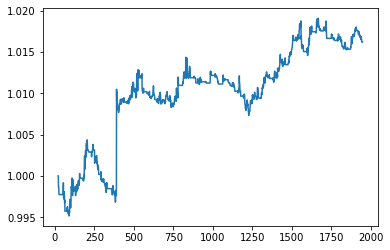

In [24]:
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  


# vizualization of strategy return
(1 + strategy_df["ret"]).cumprod().plot()

In [25]:
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))

0.17788851283351526
2.6884185662640783
0.00749918138286515


In [26]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    #max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios],index=["Return","Sharpe Ratio"])      
KPI_df.T

calculating KPIs for  AMZN
calculating KPIs for  AAPL
calculating KPIs for  TSLA
calculating KPIs for  MSFT
calculating KPIs for  GOOGL
calculating KPIs for  NVDA


,Return,Sharpe Ratio
AMZN,Ticker AMZN -0.168657 dtype: float64,Ticker AMZN -3.31482 dtype: float64
AAPL,Ticker AAPL 0.097575 dtype: float64,Ticker AAPL 0.860024 dtype: float64
TSLA,Ticker TSLA 1.148361 dtype: float64,Ticker TSLA 6.921275 dtype: float64
MSFT,Ticker MSFT -0.181888 dtype: float64,Ticker MSFT -4.169995 dtype: float64
GOOGL,Ticker GOOGL 0.320542 dtype: float64,Ticker GOOGL 3.491895 dtype: float64
NVDA,Ticker NVDA 0.234378 dtype: float64,Ticker NVDA 1.569133 dtype: float64


## 📉 Intraday Resistance Breakout Strategy:
### Performance Summary:

CAGR: 17.79%

Sharpe Ratio: 2.69

Maximum Drawdown: 0.75%

The Intraday Resistance Breakout strategy demonstrated robust performance with a strong CAGR of 17.79%, complemented by an impressive Sharpe ratio indicating excellent risk-adjusted returns. The very low maximum drawdown (0.75%) underscores the strategy's effectiveness in mitigating significant losses and capitalizing on volatility to consistently generate profitable trades​

-------------------------------------------------------------------------------------------------------------------------------

## 📈 Renko Charts with OBV Strategy

**Strategy Overview:**
Combines Renko charts—which filter price movements based on size rather than time—with the OBV indicator, tracking volume flow.

**Why this Works:**
Renko simplifies price trends while OBV confirms trend strength through volume analysis.

**Implementation Approach:**
- Generate Renko charts to filter market noise.
- Calculate OBV to confirm market sentiment.


In [27]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2
 
def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)
 
def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,5,6]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def OBV(DF, price_col='Close', volume_col='Volume'):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    # guard for missing columns
    if price_col not in df.columns or volume_col not in df.columns:
        raise KeyError(f"Need columns {price_col!r} and {volume_col!r}; got {list(df.columns)}")
    df['daily_ret'] = df[price_col].pct_change()
    df['direction'] = np.where(df['daily_ret'] >= 0, 1, -1)
    df.at[df.index[0], 'direction'] = 0
    df['vol_adj']   = df[volume_col] * df['direction']
    df['obv']       = df['vol_adj'].cumsum()
    return df['obv']


 
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR
 
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252)
    return vol
 
def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [28]:
tickers = ["AMZN","AAPL","TSLA","MSFT","GOOGL","NVDA"]

ohlc_intraday = {}


for ticker in tickers:

    ohlc_intraday[ticker] = yf.download(ticker,period="1mo",interval='5m', auto_adjust=False, multi_level_index=False)

    ohlc_intraday[ticker].dropna(inplace=True,how="all")

    #MKH:

    #ohlc_intraday[ticker].drop("Close",axis=1,inplace=True)



tickers = ohlc_intraday.keys()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
#Merging renko df with original ohlc df

ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}

for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["date","open","high","low","close","uptrend","bar_num"]    
    renko["date"] = pd.to_datetime(renko["date"], format='%Y-%m-%d %H:%M:%S%z')    
    df[ticker]["date"] = df[ticker].index    
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["date","bar_num"]],how="outer",on="date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []
    


merging for  AMZN


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  AAPL


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  TSLA


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  MSFT


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  GOOGL


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  NVDA


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\21960990.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<2:
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-2:
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])


calculating daily returns for  AMZN
calculating daily returns for  AAPL
calculating daily returns for  TSLA
calculating daily returns for  MSFT
calculating daily returns for  GOOGL
calculating daily returns for  NVDA


<AxesSubplot:>

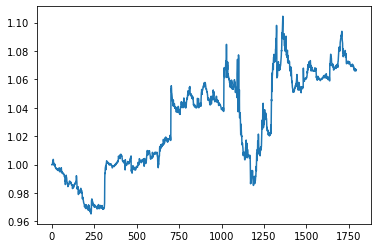

In [31]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()


In [32]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  AMZN
calculating KPIs for  AAPL
calculating KPIs for  TSLA
calculating KPIs for  MSFT
calculating KPIs for  GOOGL
calculating KPIs for  NVDA


,Return,Sharpe Ratio,Max Drawdown
AMZN,0.011128,-0.255549,0.149145
AAPL,0.006121,-0.365656,0.088872
TSLA,0.047560,0.244828,0.138650
MSFT,-0.004182,-0.775151,0.137084
GOOGL,0.000994,-0.633591,0.151859
NVDA,-0.011251,-0.518418,0.159341


## 📈 Renko & OBV Strategy:
### Performance Summary:

The Renko & OBV strategy delivered mixed performance across different assets. TSLA emerged as the best-performing stock, generating a positive return of 4.76% with a modestly positive Sharpe Ratio (0.24), indicating satisfactory risk-adjusted performance. Conversely, NVDA and MSFT reported negative returns (-1.13% and -0.42%, respectively) along with significantly negative Sharpe ratios, highlighting challenges in applying the strategy universally. Other stocks like AMZN, AAPL, and GOOGL achieved minimal positive returns but were accompanied by negative Sharpe ratios, implying suboptimal risk-adjusted returns. Moderate drawdowns (ranging from 8.89% to 15.93%) across all stocks indicate manageable risk exposure.

-------------------------------------------------------------------------------------------------------------------------------

## 📊 Renko Charts with MACD Strategy

**Strategy Overview:**
Utilizes Renko charts for trend clarity and MACD (Moving Average Convergence Divergence) to indicate trend direction and strength.

**Implementation Method:**
- Identify Renko trends.
- Confirm with MACD crossovers for precise entry/exit signals.


In [33]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,5,6]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [34]:
tickers = ["AMZN","AAPL","TSLA","MSFT","GOOGL","NVDA"]

ohlc_intraday = {}


for ticker in tickers:

    ohlc_intraday[ticker] = yf.download(ticker,period="1mo",interval='5m', auto_adjust=False, multi_level_index=False)

    ohlc_intraday[ticker].dropna(inplace=True,how="all")

    #MKH:

    #ohlc_intraday[ticker].drop("Close",axis=1,inplace=True)



tickers = ohlc_intraday.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [35]:
#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["macd"]= MACD(ohlc_renko[ticker],12,26,9)[0]
    ohlc_renko[ticker]["macd_sig"]= MACD(ohlc_renko[ticker],12,26,9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  AMZN


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  AAPL


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  TSLA


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  MSFT


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  GOOGL


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



merging for  NVDA


C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\srp51\AppData\Local\Temp\ipykernel_94276\641860207.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"].iloc[i]>=2 and ohlc_renko[ticker]["macd"].iloc[i]>ohlc_renko[ticker]["macd_sig"].iloc[i] and ohlc_renko[ticker]["macd_slope"].iloc[i]>ohlc_renko[ticker]["macd_sig_slope"].iloc[i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["bar_num"].iloc[i]<=-2 and ohlc_renko[ticker]["macd"].iloc[i]<ohlc_renko[ticker]["macd_sig"].iloc[i] and ohlc_renko[ticker]["macd_slope"].iloc[i]<ohlc_renko[ticker]["macd_sig_slope"].iloc[i]:
                    tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"].iloc[i]<=-2 and ohlc_renko[ticker]["macd"].iloc[i]<ohlc_renko[ticker]["macd_sig"].iloc[i] and ohlc_renko[ticker]["macd_slope"].iloc[i]<ohlc_renko[ticker]["macd_sig_slope"].iloc[i]:
                    tickers_signal[ticker] = "Sell"
                elif ohlc_renko[ticker]["macd"].iloc[i]<ohlc_renko[ticker]["macd_sig"].iloc[i] and ohlc_renko[ticker]["macd_slope"].iloc[i]<ohlc_renko[ticker]["macd_sig_slope"].iloc[i]:
                    tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"].iloc[i]>=2 and ohlc_renko[ticker]["macd"].iloc[i]>ohlc_renko[ticker]["macd_sig"].iloc[i] and ohlc_renko[ticker]["macd_slope"].iloc[i]>ohlc_renko[ticker]["macd_sig_slope"].iloc[i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["macd"].iloc[i]>ohlc_renko[ticker]["macd_sig"].iloc[i] and ohlc_renko[ticker]["macd_slope"].iloc[i]>ohlc_renko[ticker]["macd_sig_slope"].iloc[i]:
                    tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating daily returns for  AMZN
calculating daily returns for  AAPL
calculating daily returns for  TSLA
calculating daily returns for  MSFT
calculating daily returns for  GOOGL
calculating daily returns for  NVDA


<AxesSubplot:>

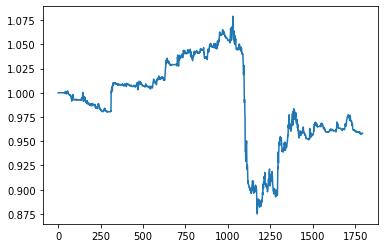

In [37]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [38]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  AMZN
calculating KPIs for  AAPL
calculating KPIs for  TSLA
calculating KPIs for  MSFT
calculating KPIs for  GOOGL
calculating KPIs for  NVDA


,Return,Sharpe Ratio,Max Drawdown
AMZN,0.537115,1.320673,0.139499
AAPL,-0.818337,-1.751295,0.225256
TSLA,1.331167,1.620458,0.271506
MSFT,-0.727071,-2.259373,0.182356
GOOGL,-0.407388,-1.440796,0.130730
NVDA,-0.647449,-0.985754,0.281349


## 📈 Renko & MACD Strategy:
### Performance Summary:

The Renko & MACD strategy displayed highly polarized results, excelling notably in TSLA and AMZN, delivering exceptional returns of 133.12% and 53.71%, respectively, coupled with positive Sharpe ratios. However, the strategy underperformed significantly for stocks like AAPL, MSFT, and NVDA, which recorded substantial negative returns. The strategy’s maximum drawdowns were generally moderate, reflecting acceptable risk management. Overall, it highlights the critical role of asset selection and customization when deploying MACD-based Renko strategies

---

# 📌 Summary of Strategy Performance and Insights

Below is a concise summary of the key performance indicators (KPIs) for each implemented algorithmic trading strategy:

| Strategy                      | CAGR / Return Range          | Sharpe Ratio Range        | Max Drawdown Range      | Overall Effectiveness               |
|-------------------------------|------------------------------|---------------------------|-------------------------|-------------------------------------|
| **Monthly Portfolio Rebalancing** | **19.16%**                  | **0.736**                 | **33.98%**              | ✅ Consistent, strong returns with moderate risk |
| **Momentum Investing**        | **Momentum-driven trades**   | **Clearly defined signals** | **-**                   | ✅ Good for capturing trends; clear buy/sell indicators |
| **Intraday Resistance Breakout** | **17.79%**                  | **2.69**                  | **0.75%**               | ✅ Excellent returns with very low risk exposure |
| **Renko & OBV**               | **-1.13% to 4.76%**          | **-0.78 to 0.24**         | **8.89% to 15.93%**     | ⚠️ Mixed results; effectiveness varies significantly by stock |
| **Renko & MACD**              | **-81.83% to 133.12%**       | **-2.26 to 1.62**         | **13.07% to 28.13%**    | ⚠️ Highly polarized; asset selection crucial |

---

## 🚩 Overall Conclusion & Recommendations

Through the comprehensive analysis of these five distinct algorithmic trading strategies, we've observed the following key insights:

- **Monthly Portfolio Rebalancing** consistently outperformed benchmarks with stable growth, making it suitable for conservative investors aiming for steady returns.
- **Momentum Investing** effectively identifies trends, providing clear trade signals, ideal for trend-following investors.
- **Intraday Resistance Breakout** achieved impressive returns coupled with extremely low drawdowns, highlighting its strength in volatility management.
- **Renko-based Strategies (OBV & MACD)** demonstrated substantial variability, strongly dependent on asset selection. While **Renko & OBV** had moderate outcomes, **Renko & MACD** showed highly polarized results, reinforcing the need for precise calibration.

**Final Recommendations**:
- Use strategies like Monthly Portfolio Rebalancing or Intraday Resistance Breakout for consistent, low-risk outcomes.
- Employ Momentum Investing to capitalize on short-term market trends.
- Renko-based strategies should be used selectively, emphasizing thorough backtesting and customization per asset to ensure profitability.

This notebook underscores the importance of strategy diversification, thorough analysis, and careful selection tailored to specific market conditions and investor risk preferences.

---
